# SBANN
## ~~Standard boring ass neural network~~
## Size and Batch Adaptable Neural Network

Import necessary packages

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import linalg as la
from scipy import spatial.distance.cdist as dist

2023-05-23 11:40:07.011127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data

Define core features of the dataset

In [2]:
dim = 3
numpart = 30
latent_dim = 2

Import and reshape data

In [3]:
fname="/Users/lorenzobarbiero/Downloads/test_30_5_0.05_0.3_0.1_10000_1000_1000_x.txt"
#fname="/Users/lorenzobarbiero/Documents/GitHub/variational-autoencoders/mc-sampling/dump/test_30_5_0.3_0.1_100000_1000_1000_x.txt"
#fname = 'mc-sampling/good-runs/test_30_5_0.05_0.3_0.1_10000_1000_1000_x.txt'

with open(fname) as f:
    data = [
        [float(i.strip()) for i in s.split(" ") if i != ""]
        for s in f.read().split("\n")
        if s != ""]

    
labels = [row[-1] for row in data]

#for row in data:
#    del row[-1]

In [4]:
print(data[1])

[3.336635, 3.919305, 2.734692, 2.592749, 4.251143, 1.946005, 2.569278, 3.558946, 1.099535, 1.667399, 3.546641, 1.910742, 3.946726, 3.046994, 3.533433, 3.616621, 4.690143, 2.065708, 2.188258, 2.073205, 3.390317, 2.870971, 1.58392, 1.38977, 0.881777, 3.249116, 2.602235, 3.601859, 3.606766, 1.670101, 3.70629, 2.790531, 2.431922, 1.024758, 2.594398, 1.747097, 3.518145, 2.076213, 3.334007, 1.493373, 1.851869, 2.595559, 2.699221, 3.27198, 2.19975, 3.862038, 1.674536, 2.120486, 2.676059, 2.141204, 2.371591, 4.356798, 3.745405, 2.542581, 4.051411, 2.062422, 1.172846, 1.13258, 2.598437, 3.509392, 2.092019, 2.509008, 1.536048, 1.824886, 2.864364, 2.783008, 4.619022, 2.99871, 1.713088, 2.896652, 2.9207, 3.160665, 2.252266, 3.891109, 2.91944, 1.303496, 3.737969, 3.581262, 3.164782, 2.567627, 1.428368, 2.143883, 3.1519, 3.877689, 3.152608, 2.577253, 4.17173, 3.995555, 3.055175, 0.792308]


In [5]:
vcs = np.array(data).reshape((-1,numpart,dim))/5
#vcs = np.array(data)
print(vcs.shape,vcs[1])

(10000, 30, 3) [[0.667327  0.783861  0.5469384]
 [0.5185498 0.8502286 0.389201 ]
 [0.5138556 0.7117892 0.219907 ]
 [0.3334798 0.7093282 0.3821484]
 [0.7893452 0.6093988 0.7066866]
 [0.7233242 0.9380286 0.4131416]
 [0.4376516 0.414641  0.6780634]
 [0.5741942 0.316784  0.277954 ]
 [0.1763554 0.6498232 0.520447 ]
 [0.7203718 0.7213532 0.3340202]
 [0.741258  0.5581062 0.4863844]
 [0.2049516 0.5188796 0.3494194]
 [0.703629  0.4152426 0.6668014]
 [0.2986746 0.3703738 0.5191118]
 [0.5398442 0.654396  0.43995  ]
 [0.7724076 0.3349072 0.4240972]
 [0.5352118 0.4282408 0.4743182]
 [0.8713596 0.749081  0.5085162]
 [0.8102822 0.4124844 0.2345692]
 [0.226516  0.5196874 0.7018784]
 [0.4184038 0.5018016 0.3072096]
 [0.3649772 0.5728728 0.5566016]
 [0.9238044 0.599742  0.3426176]
 [0.5793304 0.58414   0.632133 ]
 [0.4504532 0.7782218 0.583888 ]
 [0.2606992 0.7475938 0.7162524]
 [0.6329564 0.5135254 0.2856736]
 [0.4287766 0.63038   0.7755378]
 [0.6305216 0.5154506 0.834346 ]
 [0.799111  0.611035  0.1584

## Sorting data


In [6]:
sortmode = 3

### Option 1 - x sorted cartesian coords

In [7]:
if sortmode == 1 :
    idx = np.lexsort((vcs[:,:,1], vcs[:,:,2]))
    
    # Use the indices to sort each step while maintaining the rows intact
    sorted_vcs = np.empty_like(vcs)
    for i in range(len(vcs)):
        sorted_vcs[i] = vcs[i][idx[i]]
            
    print(sorted_vcs.shape,"\n",sorted_vcs[1])

### Option 2 - distance from origin sorted cartesian coords

In [8]:
if sortmode == 2 :
    def sort_by_distance_from_center(points):
        #center = np.mean(points, axis=0)
        distances = np.linalg.norm(points, axis=1)
        sorted_indices = np.argsort(distances)
        sorted_points = points[sorted_indices]
        return sorted_points

    for i in range (len(vcs)):
        vcs[i,:,:] = sort_by_distance_from_center(vcs[i,:,:])
    print(vcs.shape, vcs[1])

### Option 3 - distance from center of mass

In [9]:
if sortmode == 3 :
    def sort_by_distance_from_center(points):
        center = np.mean(points, axis=0)
        distances = np.linalg.norm(points-center, axis=1)
        sorted_indices = np.argsort(distances)
        sorted_points = points[sorted_indices]
        sorted_points = sorted_points
        return sorted_points - center

    for i in range (len(vcs)):
        vcs[i,:,:] = sort_by_distance_from_center(vcs[i,:,:])
    print(vcs.shape, vcs[1])

(10000, 30, 3) [[-0.01507657  0.06368274 -0.04225917]
 [ 0.02440963 -0.00657326  0.14992383]
 [-0.01970897 -0.16247246 -0.00789097]
 [ 0.18633723 -0.03260706  0.00417523]
 [-0.18994357 -0.01784046  0.07439243]
 [ 0.07803563 -0.07718786 -0.19653557]
 [ 0.11240623  0.19314774  0.06472923]
 [-0.10446757  0.18750854  0.10167883]
 [-0.13651697 -0.08891166 -0.17499957]
 [ 0.16545103  0.13063994 -0.14818897]
 [-0.22144097  0.11861494 -0.10006077]
 [-0.03637097  0.25951534 -0.09300817]
 [-0.11726917 -0.17607226  0.19585423]
 [-0.04106517  0.12107594 -0.26230217]
 [ 0.14870823 -0.17547066  0.18459223]
 [-0.12614417  0.03966674  0.29332863]
 [ 0.23442443  0.01868554  0.22447743]
 [-0.25624617 -0.22033946  0.03690263]
 [ 0.21748683 -0.25580606 -0.05811197]
 [ 0.01927343 -0.27392926 -0.20425517]
 [ 0.31643883  0.15836774  0.02630703]
 [ 0.07560083 -0.07526266  0.35213683]
 [-0.34996917 -0.07183366 -0.13278977]
 [-0.37856537  0.05910994  0.03823783]
 [ 0.16840343  0.34731534 -0.06906757]
 [ 0.36888

### Option 4 - Spherical coords

In [10]:
if sortmode == 4 :
    def convert_to_spherical_coordinates(cartesian_coords):
        x, y, z = cartesian_coords[:, 0], cartesian_coords[:, 1], cartesian_coords[:, 2]
    
        r = np.sqrt(x**2 + y**2 + z**2)
        theta = np.arccos(z / r)
        phi = np.arctan2(y, x)
    
        spherical_coords = np.column_stack((r, theta, phi))
        return spherical_coords

    for i in range(len(vcs)):
        vcs[i,:,:] = convert_to_spherical_coordinates(vcs[i,:,:])

### Compute distance matrix

In [11]:
def Distmat(inputs):
    
    numpart, dim = inputs.shape[0], inputs.shape[1]

    arrayd = []
    
    for i in range(inputs.shape[0]):
        for j in range(inputs.shape[0]):
            arrayd.append(np.linalg.norm(inputs[i,:]-inputs[j,:]))
        
    arrayd = np.array(arrayd)

    return arrayd

### Reshape and train/test split

In [12]:
#vcs = vcs.reshape((-1,90))
dm=np.zeros((len(vcs),numpart**2))

for i in range(len(vcs)):
    dm[i,:]=Distmat(vcs[i,:,:])

    
print(dm.shape,"\n",dm[1])

(10000, 900) 
 [0.         0.20839715 0.22879862 0.22802499 0.22545974 0.22872607
 0.21085438 0.20986121 0.23590853 0.21976033 0.2212348  0.20341907
 0.35302093 0.22888492 0.36807794 0.35430488 0.36799988 0.38091728
 0.39548722 0.37603788 0.35152387 0.4278743  0.37244266 0.3723235
 0.33886731 0.39985759 0.41694029 0.43003192 0.38514305 0.40367162
 0.20839715 0.         0.22617808 0.21941048 0.22755051 0.3576259
 0.23428615 0.23791733 0.37182281 0.35719936 0.37229948 0.36539483
 0.22563775 0.43647628 0.21255204 0.21300122 0.2242821  0.37045574
 0.37772303 0.44378866 0.35744608 0.21961072 0.47365112 0.42329292
 0.44037324 0.45024985 0.49077628 0.36537181 0.52286848 0.36785739
 0.22879862 0.22617808 0.         0.2438558  0.23805208 0.2289416
 0.38625619 0.37639907 0.21675005 0.37400887 0.35805195 0.43080885
 0.22630743 0.38155057 0.25609195 0.3780502  0.38909778 0.24759827
 0.2597983  0.22913128 0.46594343 0.38250428 0.36453656 0.42426942
 0.54682031 0.4447043  0.36522811 0.39425781 0.450

Split in training and test set

In [13]:
train_perc=0.8

trainset_conf = vcs[:int(train_perc*len(dm))]
print(trainset_conf.shape)
testset_conf = vcs[int(train_perc*len(dm)):]
print(testset_conf.shape)

trainset_mat = dm[:int(train_perc*len(dm))]
print(trainset_mat.shape)
testset_mat = dm[int(train_perc*len(dm)):]
print(testset_mat.shape)

(8000, 30, 3)
(2000, 30, 3)
(8000, 900)
(2000, 900)


### Sampling class

In [14]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [15]:
class DistanceMatrixLayer(layers.Layer):
    def __init__(self):
        super(DistanceMatrixLayer, self).__init__()

    def call(self, inputs):
        numpart, dim = inputs.shape[0], inputs.shape[1]

        arrayd = []
        
        for i, data in enumerate(inputs):
            for j, data in enumerate(inputs):
                arrayd[j+i*inputs.shape[0]] = np.linalg.norm(data[i]-data[j])
        
        arrayd = np.array(arrayd)

        return arrayd

In [16]:
class DistanceMatrixLayer(layers.Layer):
    def __init__(self):
        super(DistanceMatrixLayer, self).__init__()

    def call(self, inputs):
        numpart, dim = inputs.shape[1], inputs.shape[2]

        # Compute pairwise distances
        expanded_inputs = tf.expand_dims(inputs, axis=1)
        expanded_inputs_transpose = tf.transpose(expanded_inputs, perm=[0, 2, 1, 3])
        pairwise_distances = tf.norm(expanded_inputs - expanded_inputs_transpose, axis=-1)

        # Normalize distances
        #normalized_distances = pairwise_distances / (numpart * dim)

        return tf.keras.layers.Flatten()(pairwise_distances)

### Encoder

In [17]:
input_shape = (numpart**2)
inputs = layers.Input(shape=input_shape)
x = layers.Dense(int(numpart**2 *4/5), activation='relu')(inputs)
x = layers.Dense(int(numpart**2 *3/5), activation='relu')(x)
x = layers.Dense(int(numpart**2 *2/5), activation='relu')(x)
x = layers.Dense(int(numpart**2 *1/5), activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 900)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 720)          648720      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 540)          389340      ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 360)          194760      ['dense_1[0][0]']                
                                                                                            

2023-05-23 11:40:39.574360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Decoder

In [18]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(int(numpart**2 *1/5), activation="relu")(latent_inputs)
x = layers.Dense(int(numpart**2 *2/5), activation="relu")(x)
x = layers.Dense(int(numpart**2 *3/5), activation="relu")(x)
x = layers.Dense(int(numpart**2 *4/5), activation="relu")(x)
decoder_outputs = layers.Dense(numpart**2)(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 180)               540       
                                                                 
 dense_5 (Dense)             (None, 360)               65160     
                                                                 
 dense_6 (Dense)             (None, 540)               194940    
                                                                 
 dense_7 (Dense)             (None, 720)               389520    
                                                                 
 dense_8 (Dense)             (None, 900)               648900    
                                                                 
Total params: 1,299,060
Trainable params: 1,299,060
Non-tra

### VAE Class

In [19]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * (
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + reg_lambda * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Train VAE

In [20]:
reg_lambda=0.001
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001)) #lower learning rate
fit=vae.fit(trainset_mat, epochs=20, batch_size=128, verbose=2)

Epoch 1/20
63/63 - 2s - loss: 0.0855 - reconstruction_loss: 0.0803 - kl_loss: 5.1254 - 2s/epoch - 26ms/step
Epoch 2/20
63/63 - 1s - loss: 0.0204 - reconstruction_loss: 0.0180 - kl_loss: 2.4097 - 1s/epoch - 18ms/step
Epoch 3/20
63/63 - 1s - loss: 0.0197 - reconstruction_loss: 0.0178 - kl_loss: 1.8857 - 1s/epoch - 18ms/step
Epoch 4/20
63/63 - 1s - loss: 0.0195 - reconstruction_loss: 0.0177 - kl_loss: 1.7505 - 1s/epoch - 18ms/step
Epoch 5/20
63/63 - 1s - loss: 0.0194 - reconstruction_loss: 0.0177 - kl_loss: 1.6742 - 1s/epoch - 19ms/step
Epoch 6/20
63/63 - 1s - loss: 0.0193 - reconstruction_loss: 0.0177 - kl_loss: 1.6283 - 1s/epoch - 21ms/step
Epoch 7/20
63/63 - 1s - loss: 0.0193 - reconstruction_loss: 0.0177 - kl_loss: 1.5976 - 1s/epoch - 20ms/step
Epoch 8/20
63/63 - 1s - loss: 0.0192 - reconstruction_loss: 0.0177 - kl_loss: 1.5664 - 1s/epoch - 18ms/step
Epoch 9/20
63/63 - 1s - loss: 0.0192 - reconstruction_loss: 0.0177 - kl_loss: 1.5339 - 1s/epoch - 18ms/step
Epoch 10/20
63/63 - 1s - los

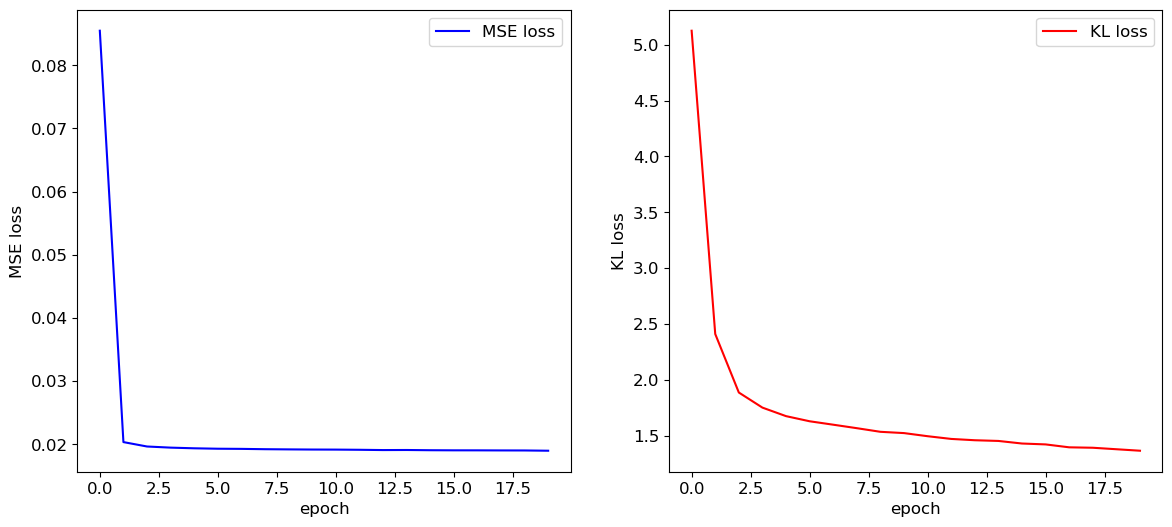

In [21]:
plt.rcParams['font.size'] = 12
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['loss'],label="MSE loss",c="b")
ax.set_xlabel('epoch')
ax.set_ylabel("MSE loss")
ax.legend()
ax=AX[1]
ax.plot(fit.history['kl_loss'],label="KL loss",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("KL loss")
ax.legend()

## Evaluate performance
We'll now use the test set to explore the latent space distribution of data and the reconstruction accuracy

In [22]:
encoded_test = np.array(vae.encoder.predict(testset_mat))

63/63 [==============================] - 0s 3ms/step


In [23]:
print(encoded_test.shape)

(3, 2000, 2)


z_mean are the first dimension, z_log_var the second (used in training), we're interested in the third dimension, which are the sampled z

In [24]:
dim1 = encoded_test[2,:,:]
print(dim1.shape)

(2000, 2)


Sampling in the latent space is reasonably gaussian as expected

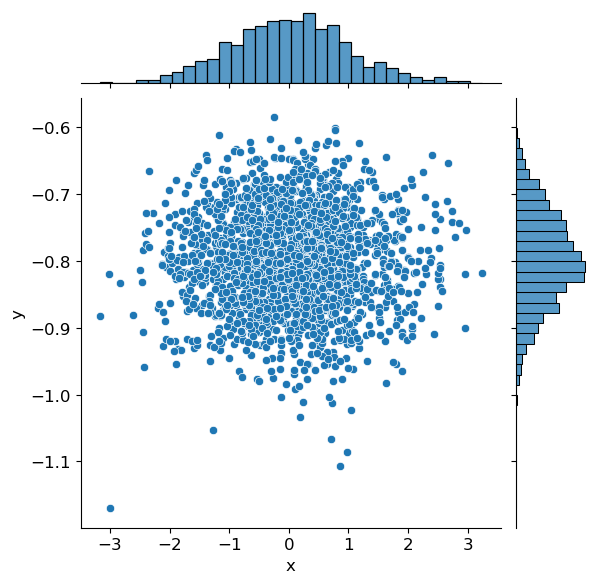

In [25]:
df = pd.DataFrame(dim1, columns=["x", "y"])
sns.jointplot(x="x", y="y", data=df);

We can now use the data to decode

In [26]:
decoded_test = np.array(decoder.predict(encoded_test[2,:,:])).reshape(-1,30,30)
print(decoded_test.shape)

63/63 [==============================] - 0s 3ms/step
(2000, 30, 30)


#### Check reconstruction

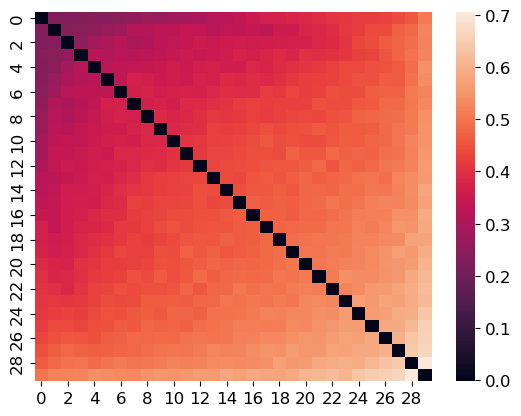

In [27]:
decoded_test[1]
df = pd.DataFrame(decoded_test[1])
sns.heatmap(data=df);

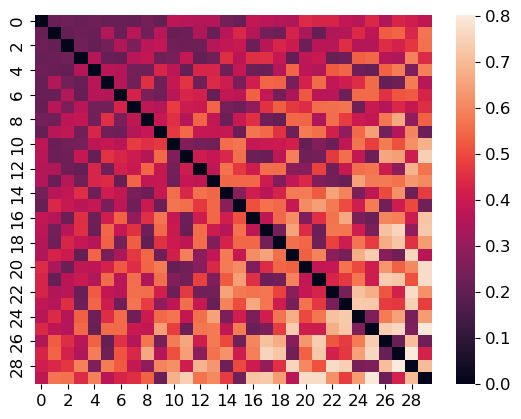

In [28]:
ts = testset_mat.reshape(-1,30,30)
df2 = pd.DataFrame(ts[1])
sns.heatmap(data=df2);

## La segunda parte

In [29]:
class CoordinateReconstructionLayer(layers.Layer):
    def __init__(self, numpart, dim):
        super(CoordinateReconstructionLayer, self).__init__()
        self.numpart = numpart
        self.dim = dim

        # Define the trainable layer(s) for coordinate reconstruction
        self.dense1 = layers.Dense(self.numpart**2, activation='softsign')
        self.dense2 = layers.Dense(self.numpart * self.dim)
 
    def call(self, inputs):
        # Reconstruct coordinates from distance matrix
        x = self.dense1(inputs)
        reconstructed_coordinates = self.dense2(x)

        # Reshape the output to match the coordinate shape
        reconstructed_coordinates = tf.reshape(reconstructed_coordinates, (-1, self.numpart, self.dim))

        return reconstructed_coordinates

In [30]:
rec_inputs = layers.Input(shape=(numpart,dim))
distance_matrix = DistanceMatrixLayer()(rec_inputs)
x = layers.Dense(int(numpart**2 *4/5), activation='softsign')(distance_matrix)
rec_outputs = CoordinateReconstructionLayer(numpart,dim)(x)
reconstruction = keras.Model(rec_inputs,rec_outputs)
reconstruction.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 3)]           0         
                                                                 
 distance_matrix_layer (Dist  (None, 900)              0         
 anceMatrixLayer)                                                
                                                                 
 dense_9 (Dense)             (None, 720)               648720    
                                                                 
 coordinate_reconstruction_l  (None, 30, 3)            729990    
 ayer (CoordinateReconstruct                                     
 ionLayer)                                                       
                                                                 
Total params: 1,378,710
Trainable params: 1,378,710
Non-trainable params: 0
___________________________________________________

In [31]:
reconstruction.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.MeanSquaredError()) #lower learning rate
fit=reconstruction.fit(trainset_conf, trainset_conf, epochs=20, batch_size=128, verbose=2)

Epoch 1/20
63/63 - 1s - loss: 0.0429 - 807ms/epoch - 13ms/step
Epoch 2/20
63/63 - 1s - loss: 0.0367 - 622ms/epoch - 10ms/step
Epoch 3/20
63/63 - 1s - loss: 0.0359 - 611ms/epoch - 10ms/step
Epoch 4/20
63/63 - 1s - loss: 0.0355 - 624ms/epoch - 10ms/step
Epoch 5/20
63/63 - 1s - loss: 0.0353 - 625ms/epoch - 10ms/step
Epoch 6/20
63/63 - 1s - loss: 0.0351 - 618ms/epoch - 10ms/step
Epoch 7/20
63/63 - 1s - loss: 0.0351 - 630ms/epoch - 10ms/step
Epoch 8/20
63/63 - 1s - loss: 0.0350 - 636ms/epoch - 10ms/step
Epoch 9/20
63/63 - 1s - loss: 0.0350 - 617ms/epoch - 10ms/step
Epoch 10/20
63/63 - 1s - loss: 0.0349 - 617ms/epoch - 10ms/step
Epoch 11/20
63/63 - 1s - loss: 0.0349 - 657ms/epoch - 10ms/step
Epoch 12/20
63/63 - 1s - loss: 0.0348 - 781ms/epoch - 12ms/step
Epoch 13/20
63/63 - 1s - loss: 0.0349 - 615ms/epoch - 10ms/step
Epoch 14/20
63/63 - 1s - loss: 0.0348 - 612ms/epoch - 10ms/step
Epoch 15/20
63/63 - 1s - loss: 0.0348 - 604ms/epoch - 10ms/step
Epoch 16/20
63/63 - 1s - loss: 0.0348 - 608ms/epo

In [32]:
rec_test = np.array(reconstruction.predict(testset_conf))

63/63 [==============================] - 0s 3ms/step


In [33]:
print(rec_test.shape)
print(rec_test[1])

(2000, 30, 3)
[[-0.0155611   0.00161273 -0.00889092]
 [ 0.01852161 -0.0060063   0.00630427]
 [ 0.02330735  0.0006742   0.04223184]
 [ 0.005228    0.01960141  0.00242528]
 [-0.02345891 -0.03631556  0.02470109]
 [ 0.00654495 -0.01857746 -0.00449638]
 [ 0.0194449   0.01821301 -0.02946424]
 [-0.01913748  0.01212606 -0.02869682]
 [-0.0334769   0.01358017 -0.01663324]
 [ 0.03701762 -0.01288417 -0.00452601]
 [ 0.0272381  -0.05039639 -0.02723079]
 [ 0.0404938  -0.01623352  0.016071  ]
 [-0.00396638 -0.00565049 -0.00244325]
 [-0.04124738 -0.03625908  0.02360924]
 [ 0.00302917 -0.01153448 -0.00551227]
 [-0.03775933  0.02163511 -0.00495307]
 [ 0.04098468  0.03582498  0.00506938]
 [-0.00383637 -0.03329559  0.01733592]
 [ 0.00130608  0.00097119 -0.01999029]
 [-0.03858669  0.03594897 -0.00474292]
 [-0.01932749 -0.01267911 -0.03176157]
 [ 0.00422422 -0.00612375 -0.06644666]
 [ 0.03496835 -0.00894915 -0.02559891]
 [ 0.0119652  -0.00147965 -0.01063173]
 [-0.03469983  0.02927379  0.00320542]
 [ 0.014190

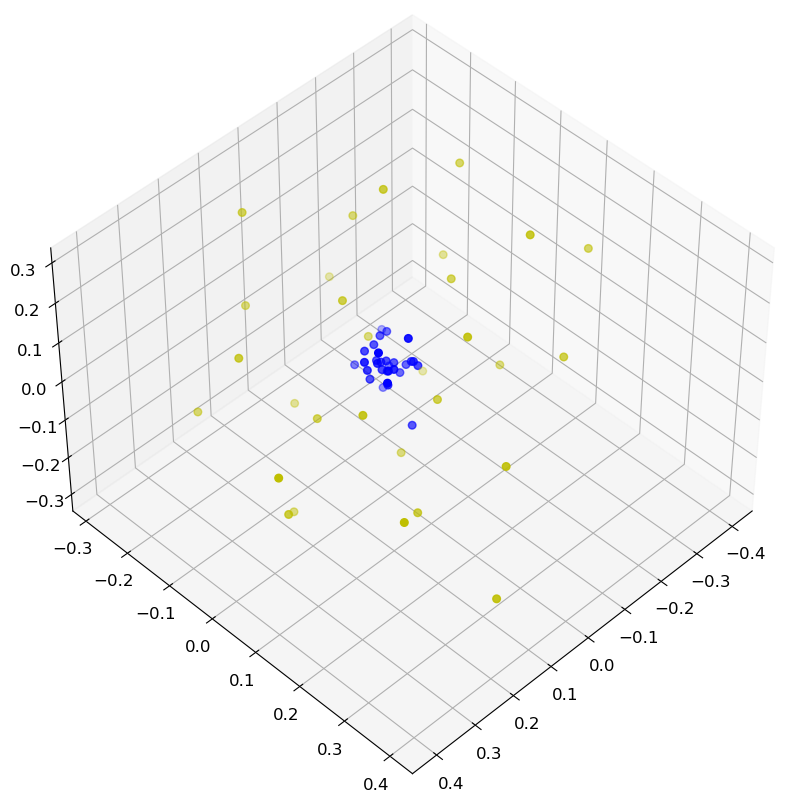

In [34]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(rec_test[1,:,0], rec_test[1,:,1], rec_test[1,:,2], s=30, c="b", depthshade=True)
ax.scatter(testset_conf[1,:,0], testset_conf[1,:,1], testset_conf[1,:,2], s=30, c="y", depthshade=True)
ax.view_init(45,45)

## Third time's the charm

In [37]:
encoded_train = np.array(vae.encoder.predict(trainset_mat))
decoded_train = np.array(decoder.predict(encoded_train[2,:,:]))

250/250 [==============================] - 1s 3ms/step


In [44]:
input_shape = (numpart**2)
r_inputs = layers.Input(shape=input_shape)
x = layers.Dense(int(numpart**2 *4/5), activation='relu')(r_inputs)
x = layers.Dense(int(numpart**2 *3/5), activation="relu")(x)
x = layers.Dense(int(numpart**2 *2/5), activation="relu")(x)
x = layers.Dense(int(numpart**2 *1/5), activation="relu")(x)
decoder_outputs = layers.Dense(numpart*dim)(x)
r_outputs = layers.Dense(numpart*dim)(x)
reconstruction2 = keras.Model(r_inputs,r_outputs)
reconstruction2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 900)]             0         
                                                                 
 dense_31 (Dense)            (None, 720)               648720    
                                                                 
 dense_32 (Dense)            (None, 540)               389340    
                                                                 
 dense_33 (Dense)            (None, 360)               194760    
                                                                 
 dense_34 (Dense)            (None, 180)               64980     
                                                                 
 dense_36 (Dense)            (None, 90)                16290     
                                                                 
Total params: 1,314,090
Trainable params: 1,314,090
Non-tra

In [47]:
reconstruction2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.MeanSquaredError()) #lower learning rate
fit=reconstruction2.fit(decoded_train, trainset_conf.reshape(-1,90), epochs=20, batch_size=128, verbose=2)

Epoch 1/20
63/63 - 1s - loss: 0.0363 - 803ms/epoch - 13ms/step
Epoch 2/20
63/63 - 1s - loss: 0.0345 - 576ms/epoch - 9ms/step
Epoch 3/20
63/63 - 1s - loss: 0.0345 - 566ms/epoch - 9ms/step
Epoch 4/20
63/63 - 1s - loss: 0.0345 - 571ms/epoch - 9ms/step
Epoch 5/20
63/63 - 1s - loss: 0.0345 - 567ms/epoch - 9ms/step
Epoch 6/20
63/63 - 1s - loss: 0.0345 - 564ms/epoch - 9ms/step
Epoch 7/20
63/63 - 1s - loss: 0.0345 - 578ms/epoch - 9ms/step
Epoch 8/20
63/63 - 1s - loss: 0.0345 - 594ms/epoch - 9ms/step
Epoch 9/20
63/63 - 1s - loss: 0.0345 - 573ms/epoch - 9ms/step
Epoch 10/20
63/63 - 1s - loss: 0.0345 - 568ms/epoch - 9ms/step
Epoch 11/20
63/63 - 1s - loss: 0.0345 - 565ms/epoch - 9ms/step
Epoch 12/20
63/63 - 1s - loss: 0.0345 - 609ms/epoch - 10ms/step
Epoch 13/20
63/63 - 1s - loss: 0.0345 - 573ms/epoch - 9ms/step
Epoch 14/20
63/63 - 1s - loss: 0.0345 - 665ms/epoch - 11ms/step
Epoch 15/20
63/63 - 1s - loss: 0.0345 - 579ms/epoch - 9ms/step
Epoch 16/20
63/63 - 1s - loss: 0.0345 - 566ms/epoch - 9ms/ste

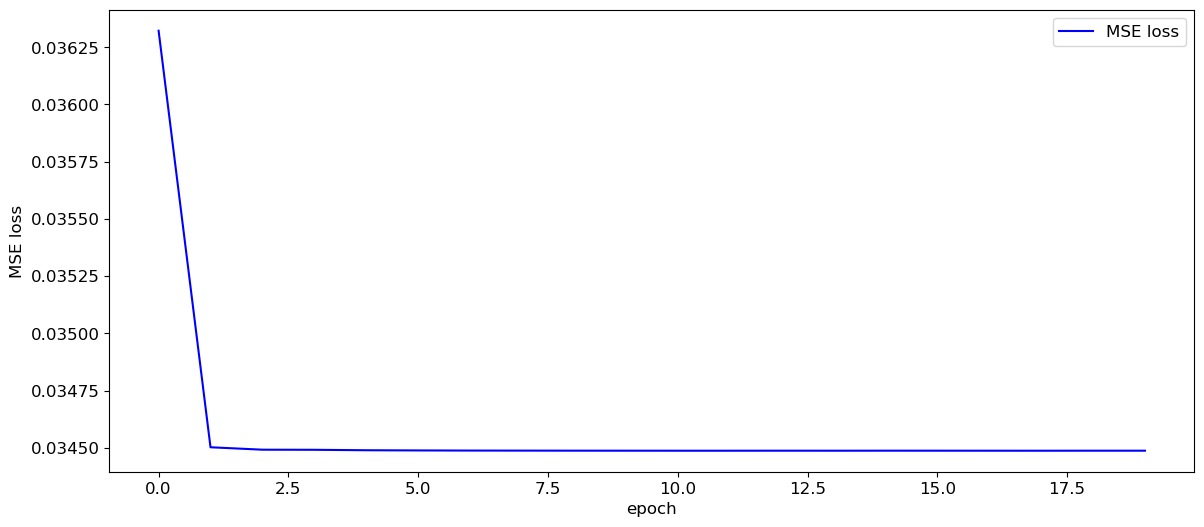

In [58]:
fig,ax=plt.subplots(1,figsize=(14,6.))
ax.plot(fit.history['loss'],label="MSE loss",c="b")
ax.set_xlabel('epoch')
ax.set_ylabel("MSE loss")
ax.legend()

In [54]:
r_test = np.array(reconstruction2.predict(testset_mat)).reshape(-1,30,3)
print(r_test[1])

63/63 [==============================] - 0s 3ms/step
[[ 0.01857401 -0.00051005  0.02275204]
 [-0.01479351 -0.00266998  0.01051222]
 [ 0.01077814  0.03212117 -0.0056739 ]
 [ 0.00371962  0.00042944  0.0244177 ]
 [ 0.00730914  0.00843392 -0.01357855]
 [ 0.01252185  0.00715866 -0.00959058]
 [ 0.00401753 -0.00902877  0.00069428]
 [ 0.0065249   0.0038885  -0.00284353]
 [-0.010899    0.02123518  0.00106628]
 [-0.0019713   0.00969525  0.01327813]
 [-0.00438964 -0.01735334 -0.01596808]
 [-0.00780348  0.00391573 -0.02447297]
 [-0.00512815 -0.0052812   0.01255799]
 [-0.03096921 -0.02567046  0.00466058]
 [-0.02766361 -0.02329933  0.013793  ]
 [-0.01967605  0.00103823 -0.00591884]
 [ 0.00050708  0.01182559  0.01561418]
 [ 0.01258138 -0.01389879 -0.01633529]
 [ 0.00951446  0.00834479 -0.00271718]
 [-0.00414417 -0.00220333  0.00640715]
 [-0.00618557  0.00913232  0.01702176]
 [ 0.00038755 -0.01179942  0.00349152]
 [ 0.01725989 -0.00563439  0.00223865]
 [-0.02314238 -0.00337864 -0.01484946]
 [-0.003296

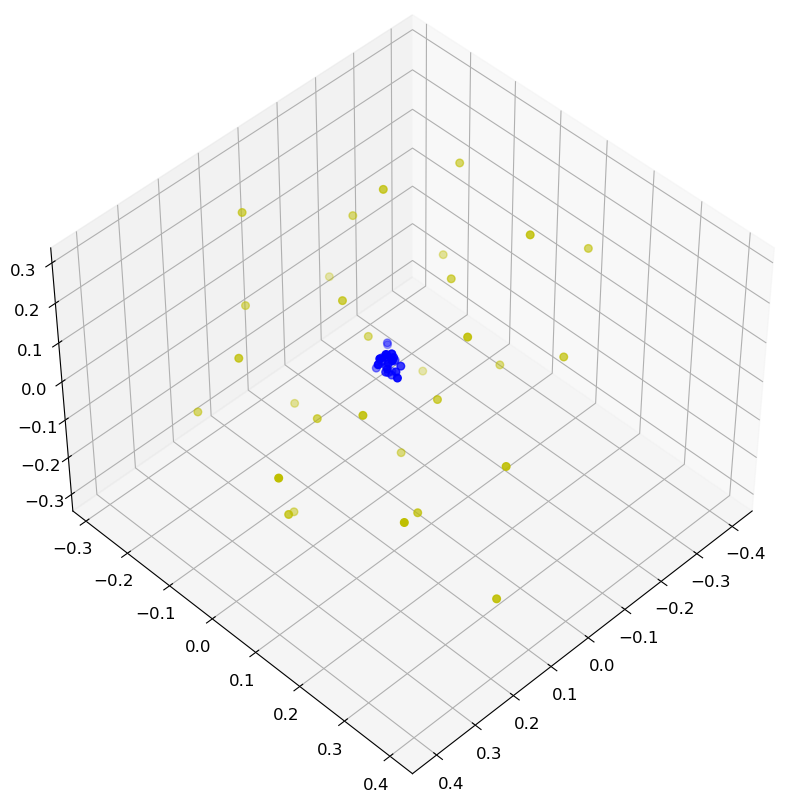

In [52]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(r_test[1,:,0], r_test[1,:,1], r_test[1,:,2], s=30, c="b", depthshade=True)
ax.scatter(testset_conf[1,:,0], testset_conf[1,:,1], testset_conf[1,:,2], s=30, c="y", depthshade=True)
ax.view_init(45,45)

## Deez Labels

In [35]:
def label_vis(vae, data, labels):
    
    #prediction
    z_mean, _, _ = vae.encoder.predict(data)
    
    #PCA on z_mean
    A = pd.DataFrame(z_mean)
    l, V = la.eig(np.cov(A.T))
    lr = np.copy(l.real)
    n1 = np.argmax(l)
    l[n1] = 0
    n2 = np.argmax(l)
    print(lr[n1]/sum(lr), lr[n2]/sum(lr), (lr[n1]+lr[n2])/sum(lr) )

    #plot
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, n1], z_mean[:, n2], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

In [36]:
label_vis(vae, vcs, labels)

InvalidArgumentError: Graph execution error:

Detected at node 'encoder/dense/Relu' defined at (most recent call last):
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/mm/583s4ppn42l0g18_9qw8b3hm0000gn/T/ipykernel_33953/3016866306.py", line 1, in <module>
      label_vis(vae, vcs, labels)
    File "/var/folders/mm/583s4ppn42l0g18_9qw8b3hm0000gn/T/ipykernel_33953/3558991256.py", line 4, in label_vis
      z_mean, _, _ = vae.encoder.predict(data)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1983, in predict_step
      return self(x, training=False)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/layers/core/dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/Users/lorenzobarbiero/anaconda3/lib/python3.10/site-packages/keras/backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'encoder/dense/Relu'
In[0] and In[1] has different ndims: [32,30,3] vs. [900,720]
	 [[{{node encoder/dense/Relu}}]] [Op:__inference_predict_function_15404]